In [1]:
#allows access to google drive and stock data
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
#lists the contents of the project data folder
!ls /content/drive/Shareddrives/Group3_IoTManagement_Project/ProjectData_Group3

archive.zip


In [3]:
#unzips the archive.zip file which contains all stock data

!unzip /content/drive/Shareddrives/Group3_IoTManagement_Project/ProjectData_Group3/archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: Data/Stocks/EVLO.csv    
  inflating: Data/Stocks/EVLV.csv    
  inflating: Data/Stocks/EVLVW.csv   
  inflating: Data/Stocks/EVM.csv     
  inflating: Data/Stocks/EVN.csv     
  inflating: Data/Stocks/EVO.csv     
  inflating: Data/Stocks/EVOJ.csv    
  inflating: Data/Stocks/EVOJU.csv   
  inflating: Data/Stocks/EVOJW.csv   
  inflating: Data/Stocks/EVOK.csv    
  inflating: Data/Stocks/EVR.csv     
  inflating: Data/Stocks/EVRG.csv    
  inflating: Data/Stocks/EVRI.csv    
  inflating: Data/Stocks/EVT.csv     
  inflating: Data/Stocks/EVTC.csv    
  inflating: Data/Stocks/EVTL.csv    
  inflating: Data/Stocks/EVTV.csv    
  inflating: Data/Stocks/EVV.csv     
  inflating: Data/Stocks/EW.csv      
  inflating: Data/Stocks/EWBC.csv    
  inflating: Data/Stocks/EWCZ.csv    
  inflating: Data/Stocks/EWTX.csv    
  inflating: Data/Stocks/EXAI.csv    
  inflating: Data/Stocks/EXAS.csv    
  inflating: Data/Stocks/EXC.csv     

In [4]:
# Install pyspark in this notebook

!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=e943ffb35ae815a49a906e9576c877ec7b93a9044104176d99b5d42ca165ba74
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [5]:
# Create the spark session

from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [6]:
# List the spark session details and confirms that spark loaded correctly

spark

In [7]:
# Import necessary libraries

import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import unix_timestamp
from pyspark.sql.types import LongType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
import matplotlib.pyplot as plt

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer


from numpy import double
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType

from scipy.stats import f_oneway
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [8]:
# Produce summary statistics for linear regression

def modelsummary(model, param_names):
    #import numpy as np
    print ("Note: the last rows are the information for Intercept")
    print ("##","-------------------------------------------------")
    print ("##","  Estimate   |   Std.Error | t Values  |  P-value")
    coef = np.append(list(model.coefficients), model.intercept)
    Summary=model.summary
    param_names.append('intercept')

    for i in range(len(Summary.pValues)):
        print ("##",'{:10.6f}'.format(coef[i]),\
        '{:14.6f}'.format(Summary.coefficientStandardErrors[i]),\
        '{:12.3f}'.format(Summary.tValues[i]),\
        '{:12.6f}'.format(Summary.pValues[i]), \
        param_names[i])

    print ("##",'---')
    print ("##","Mean squared error: % .6f" \
           % Summary.meanSquaredError, ", RMSE: % .6f" \
           % Summary.rootMeanSquaredError )
    print ("##","Multiple R-squared: %f" % Summary.r2, "," )
    print ("##","Multiple Adjusted R-squared: %f" % Summary.r2adj, ", \
            Total iterations: %i"% Summary.totalIterations)

In [9]:
# Custom linear regression model with best fit line plotted

def lr_model(i,s,e):
  # Read data into Pandas DataFrame and convert date column to datetime object
  data = pd.read_csv(i)
  data['Date'] = pd.to_datetime(data['Date'])


  data2 = data[s:e]
  # Convert Pandas DataFrame to PySpark DataFrame

  spark_df = spark.createDataFrame(data2)

  # Convert date column to LongType column representing milliseconds since epoch
  spark_df = spark_df.withColumn('Date', (unix_timestamp(spark_df['Date']) * 1000).cast(LongType()))

  # Create scatter plot with dates as x-axis and numeric data as y-axis
  plt.scatter(data2['Date'], data2['Open'])
  plt.xlabel('Date')
  plt.ylabel('Stock Price')


  # Use VectorAssembler to combine date and numeric data into feature column
  assembler = VectorAssembler(inputCols=['Date'], outputCol='features')
  spark_df = assembler.transform(spark_df)

  # Fit linear regression model to data
  lr = LinearRegression(featuresCol='features', labelCol='Open')
  model = lr.fit(spark_df)



  # Make predictions and convert PySpark DataFrame to Pandas DataFrame
  predictions = model.transform(spark_df)
  predictions = predictions.select(['Date', 'prediction']).toPandas()

  # Convert date column from LongType back to datetime object
  predictions['Date'] = pd.to_datetime(predictions['Date'], unit='ms')

  # Create line plot with dates as x-axis and predicted values as y-axis
  plt.plot(predictions['Date'], predictions['prediction'],color='red')
  plt.xlabel('Date')
  plt.ylabel('Predicted Numeric Data')
  plt.show()

  print("Coefficients: {} Intercept: {}".format(model.coefficients, model.intercept))
  param_names = ["Date"]
  modelsummary(model, param_names)

In [10]:
# Linear regression model function version 2: Allows selection of dates for analysis

def lr_model2(i,s,e):
   # Read data into Pandas DataFrame and convert date column to datetime object
  data = pd.read_csv(i)
  data['Date'] = pd.to_datetime(data['Date'])


  data2 = spark.createDataFrame(data)

  data2.createOrReplaceTempView("data_view")

  data2 = spark.sql("SELECT * FROM data_view WHERE Date BETWEEN '" + str(s) + "' AND '" + str(e) + "'")


  # Convert Pandas DataFrame to PySpark DataFrame
  spark_df = data2

  # Convert date column to LongType column representing milliseconds since epoch
  spark_df = spark_df.withColumn('Date', (unix_timestamp(spark_df['Date']) * 1000).cast(LongType()))

  # Create scatter plot with dates as x-axis and numeric data as y-axis
  plt.scatter(data2.select('Date').collect(), data2.select('Open').collect())
  plt.xticks(rotation=45, ha='right')
  plt.xlabel('Date')
  plt.ylabel('Stock Price')


  # Use VectorAssembler to combine date and numeric data into feature column
  assembler = VectorAssembler(inputCols=['Date'], outputCol='features')
  spark_df = assembler.transform(spark_df)

  # Fit linear regression model to data
  lr = LinearRegression(featuresCol='features', labelCol='Open')
  model = lr.fit(spark_df)



  # Make predictions and convert PySpark DataFrame to Pandas DataFrame
  predictions = model.transform(spark_df)
  predictions = predictions.select(['Date', 'prediction']).toPandas()

  # Convert date column from LongType back to datetime object
  predictions['Date'] = pd.to_datetime(predictions['Date'], unit='ms')

  # Create line plot with dates as x-axis and predicted values as y-axis
  plt.plot(predictions['Date'], predictions['prediction'],color='red')
  plt.xlabel('Date')
  plt.ylabel('Stock Price')
  plt.show()

  print("Coefficients: {} Intercept: {}".format(model.coefficients, model.intercept))
  param_names = ["Date"]
  modelsummary(model, param_names)

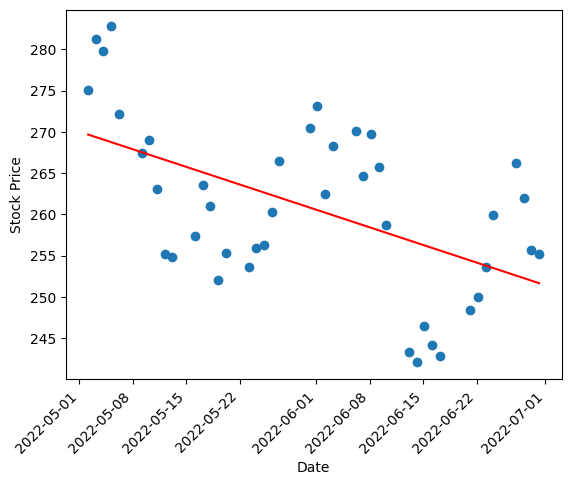

Coefficients: [-3.532323315356071e-09] Intercept: 6103.171623549518
Note: the last rows are the information for Intercept
## -------------------------------------------------
##   Estimate   |   Std.Error | t Values  |  P-value
##  -0.000000       0.000000       -3.984     0.000279 Date
## 6103.171624    1466.524792        4.162     0.000163 intercept
## ---
## Mean squared error:  75.302969 , RMSE:  8.677728
## Multiple R-squared: 0.284059 ,
## Multiple Adjusted R-squared: 0.266161 ,             Total iterations: 0


In [11]:
# Run linear regression model v2 on Microsoft csv for dates staring May 2022 until July 2022

lr_model2('/content/Data/StockHistory/MSFT.csv','2022-05','2022-07')

In [12]:
df = pd.read_csv('Data/Stocks/MSFT.csv')
display(df)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1986-03-13 00:00:00-05:00,0.055241,0.063365,0.055241,0.060657,1031788800,0.0,0.0
1,1986-03-14 00:00:00-05:00,0.060657,0.063907,0.060657,0.062823,308160000,0.0,0.0
2,1986-03-17 00:00:00-05:00,0.062823,0.064448,0.062823,0.063907,133171200,0.0,0.0
3,1986-03-18 00:00:00-05:00,0.063907,0.064448,0.061740,0.062281,67766400,0.0,0.0
4,1986-03-19 00:00:00-05:00,0.062281,0.062823,0.060657,0.061198,47894400,0.0,0.0
...,...,...,...,...,...,...,...,...
9332,2023-03-23 00:00:00-04:00,277.940002,281.059998,275.200012,277.660004,36610900,0.0,0.0
9333,2023-03-24 00:00:00-04:00,277.239990,280.630005,275.279999,280.570007,28172000,0.0,0.0
9334,2023-03-27 00:00:00-04:00,280.500000,281.459991,275.519989,276.380005,26840200,0.0,0.0
9335,2023-03-28 00:00:00-04:00,275.790009,276.140015,272.049988,275.230011,21878600,0.0,0.0


In [13]:
import pandas_datareader as data

In [14]:
import pandas as pd

start_date = pd.Timestamp('2018-03-28', tz='UTC')
end_date = pd.Timestamp('2023-03-29', tz='UTC')

df = pd.read_csv('Data/Stocks/MSFT.csv')
df['Date'] = pd.to_datetime(df['Date'], utc=True)  # Convert 'Date' column to datetime with UTC timezone
df = df.set_index('Date')  # Set 'Date' column as index with UTC timezone

df = df.loc[start_date:end_date]  # Filter rows between start and end dates

df.head()



,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-03-28 04:00:00+00:00,84.769852,86.100578,83.873269,84.364029,52501100,0.0,0.0
2018-03-29 04:00:00+00:00,85.109602,87.100968,83.429685,86.138313,45867500,0.0,0.0
2018-04-02 04:00:00+00:00,85.383280,85.770224,82.589708,83.542915,48515400,0.0,0.0
2018-04-03 04:00:00+00:00,84.543335,84.986910,82.948354,84.666023,37213800,0.0,0.0
2018-04-04 04:00:00+00:00,82.910597,87.544533,82.797348,87.138710,35560000,0.0,0.0


In [15]:
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-03-22 04:00:00+00:00,273.399994,281.040009,272.179993,272.290009,34873300,0.0,0.0
2023-03-23 04:00:00+00:00,277.940002,281.059998,275.200012,277.660004,36610900,0.0,0.0
2023-03-24 04:00:00+00:00,277.239990,280.630005,275.279999,280.570007,28172000,0.0,0.0
2023-03-27 04:00:00+00:00,280.500000,281.459991,275.519989,276.380005,26840200,0.0,0.0
2023-03-28 04:00:00+00:00,275.790009,276.140015,272.049988,275.230011,21878600,0.0,0.0


In [16]:
df = df.drop(['Dividends','Stock Splits'], axis=1)


In [17]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2018-03-28 04:00:00+00:00,84.769852,86.100578,83.873269,84.364029,52501100
2018-03-29 04:00:00+00:00,85.109602,87.100968,83.429685,86.138313,45867500
2018-04-02 04:00:00+00:00,85.383280,85.770224,82.589708,83.542915,48515400
2018-04-03 04:00:00+00:00,84.543335,84.986910,82.948354,84.666023,37213800
2018-04-04 04:00:00+00:00,82.910597,87.544533,82.797348,87.138710,35560000


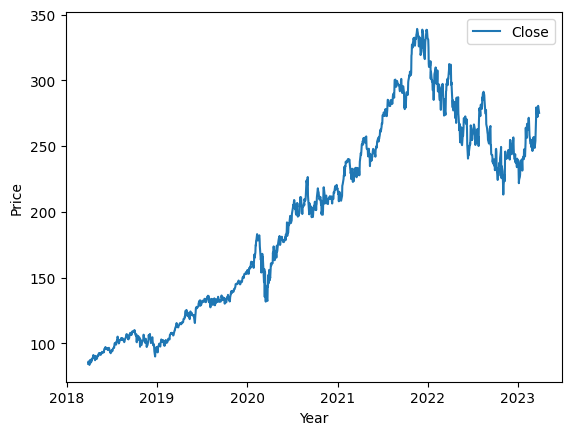

In [18]:
plt.plot(df.Close, label = 'Close')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()
plt.show()

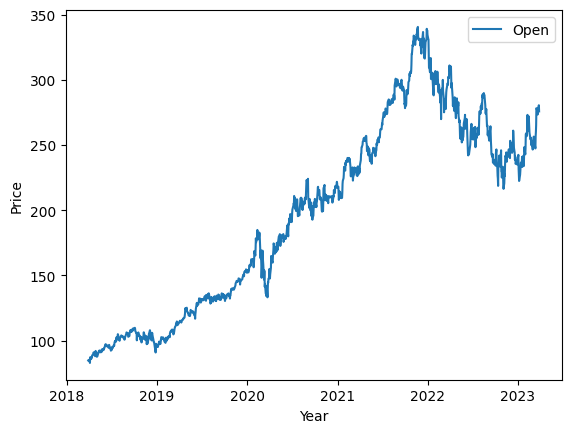

In [19]:
plt.plot(df.Open, label = 'Open')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()
plt.show()

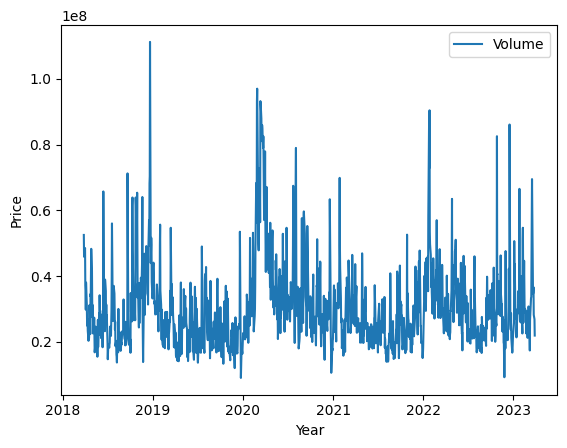

In [20]:
plt.plot(df.Volume, label = 'Volume')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()
plt.show()


In [21]:
df

,Open,High,Low,Close,Volume
Date,,,,,
2018-03-28 04:00:00+00:00,84.769852,86.100578,83.873269,84.364029,52501100
2018-03-29 04:00:00+00:00,85.109602,87.100968,83.429685,86.138313,45867500
2018-04-02 04:00:00+00:00,85.383280,85.770224,82.589708,83.542915,48515400
2018-04-03 04:00:00+00:00,84.543335,84.986910,82.948354,84.666023,37213800
2018-04-04 04:00:00+00:00,82.910597,87.544533,82.797348,87.138710,35560000
...,...,...,...,...,...
2023-03-22 04:00:00+00:00,273.399994,281.040009,272.179993,272.290009,34873300
2023-03-23 04:00:00+00:00,277.940002,281.059998,275.200012,277.660004,36610900
2023-03-24 04:00:00+00:00,277.239990,280.630005,275.279999,280.570007,28172000


In [22]:
ma90 = df.Close.rolling(90).mean()
ma90

Date
2018-03-28 04:00:00+00:00           NaN
2018-03-29 04:00:00+00:00           NaN
2018-04-02 04:00:00+00:00           NaN
2018-04-03 04:00:00+00:00           NaN
2018-04-04 04:00:00+00:00           NaN
                                ...    
2023-03-22 04:00:00+00:00    248.730653
2023-03-23 04:00:00+00:00    249.130300
2023-03-24 04:00:00+00:00    249.516634
2023-03-27 04:00:00+00:00    249.917863
2023-03-28 04:00:00+00:00    250.301673
Name: Close, Length: 1259, dtype: float64

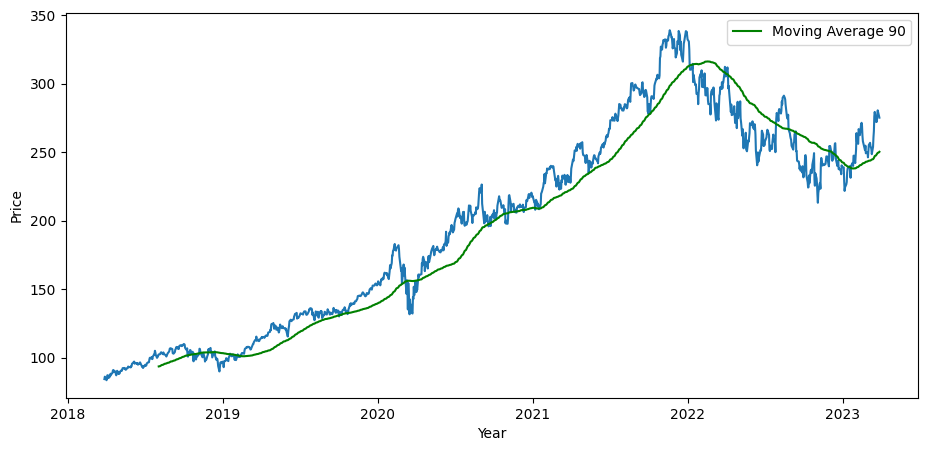

In [23]:
plt.figure(figsize = (11,5))
plt.plot(df.Close)
plt.plot(ma90, 'g', label = 'Moving Average 90')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()
plt.show()


In [24]:
ma180 = df.Close.rolling(180).mean()
ma180

Date
2018-03-28 04:00:00+00:00           NaN
2018-03-29 04:00:00+00:00           NaN
2018-04-02 04:00:00+00:00           NaN
2018-04-03 04:00:00+00:00           NaN
2018-04-04 04:00:00+00:00           NaN
                                ...    
2023-03-22 04:00:00+00:00    250.926693
2023-03-23 04:00:00+00:00    251.001261
2023-03-24 04:00:00+00:00    251.079919
2023-03-27 04:00:00+00:00    251.139380
2023-03-28 04:00:00+00:00    251.209822
Name: Close, Length: 1259, dtype: float64

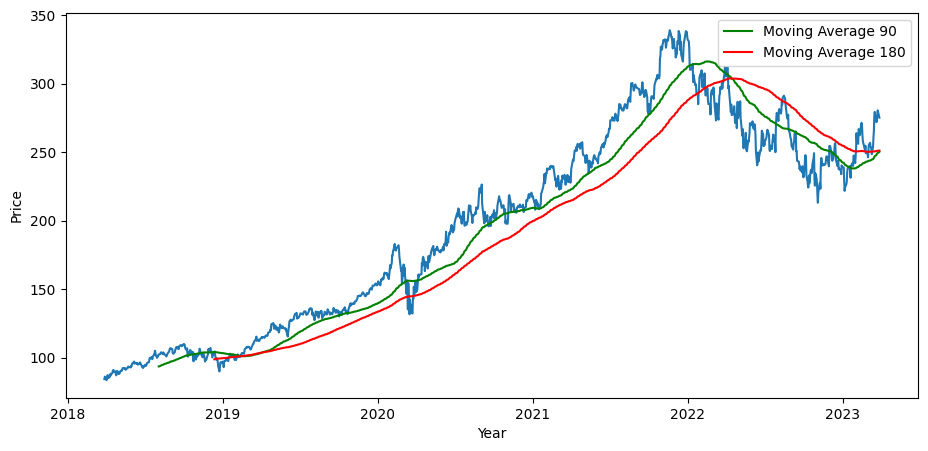

In [25]:
plt.figure(figsize = (11,5))
plt.plot(df.Close)
plt.plot(ma90, 'g', label = 'Moving Average 90')
plt.plot(ma180, 'r', label = 'Moving Average 180')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()
plt.show()

In [26]:
df

,Open,High,Low,Close,Volume
Date,,,,,
2018-03-28 04:00:00+00:00,84.769852,86.100578,83.873269,84.364029,52501100
2018-03-29 04:00:00+00:00,85.109602,87.100968,83.429685,86.138313,45867500
2018-04-02 04:00:00+00:00,85.383280,85.770224,82.589708,83.542915,48515400
2018-04-03 04:00:00+00:00,84.543335,84.986910,82.948354,84.666023,37213800
2018-04-04 04:00:00+00:00,82.910597,87.544533,82.797348,87.138710,35560000
...,...,...,...,...,...
2023-03-22 04:00:00+00:00,273.399994,281.040009,272.179993,272.290009,34873300
2023-03-23 04:00:00+00:00,277.940002,281.059998,275.200012,277.660004,36610900
2023-03-24 04:00:00+00:00,277.239990,280.630005,275.279999,280.570007,28172000


In [28]:
# Split Data into Training and Testing Testing
data_training = pd.DataFrame(df['Close'][0:int(len(df)*0.75)])
data_testing = pd.DataFrame(df['Close'][int(len(df)*0.75): int(len(df))])

print(data_training.shape)
print(data_testing.shape)

(944, 1)
(315, 1)


In [29]:
data_training.head()

,Close
Date,
2018-03-28 04:00:00+00:00,84.364029
2018-03-29 04:00:00+00:00,86.138313
2018-04-02 04:00:00+00:00,83.542915
2018-04-03 04:00:00+00:00,84.666023
2018-04-04 04:00:00+00:00,87.138710


In [30]:
data_training.tail()

,Close
Date,
2021-12-17 05:00:00+00:00,319.992584
2021-12-20 05:00:00+00:00,316.148346
2021-12-21 05:00:00+00:00,323.441589
2021-12-22 05:00:00+00:00,329.282104
2021-12-23 05:00:00+00:00,330.754578


In [31]:
data_testing.head()

,Close
Date,
2021-12-27 05:00:00+00:00,338.423309
2021-12-28 05:00:00+00:00,337.237427
2021-12-29 05:00:00+00:00,337.929230
2021-12-30 05:00:00+00:00,335.330139
2021-12-31 05:00:00+00:00,332.365448


In [32]:
data_testing.tail()

,Close
Date,
2023-03-22 04:00:00+00:00,272.290009
2023-03-23 04:00:00+00:00,277.660004
2023-03-24 04:00:00+00:00,280.570007
2023-03-27 04:00:00+00:00,276.380005
2023-03-28 04:00:00+00:00,275.230011


In [33]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

In [34]:
data_training_array = scaler.fit_transform(data_training)
data_training_array


array([[0.00321334],
       [0.01015682],
       [0.        ],
       [0.00439516],
       [0.01407176],
       [0.01425646],
       [0.00631576],
       [0.00831017],
       [0.01610319],
       [0.01233592],
       [0.01868843],
       [0.01684185],
       [0.02086756],
       [0.02788499],
       [0.02925151],
       [0.02803273],
       [0.02393306],
       [0.02522571],
       [0.01698946],
       [0.01399799],
       [0.02119999],
       [0.02696164],
       [0.01846693],
       [0.02393306],
       [0.01842987],
       [0.02049824],
       [0.02452404],
       [0.02843896],
       [0.02692471],
       [0.03109825],
       [0.03468077],
       [0.03390512],
       [0.03512393],
       [0.03250167],
       [0.03342899],
       [0.02983091],
       [0.03049857],
       [0.03509826],
       [0.03472728],
       [0.03903022],
       [0.03773181],
       [0.0379174 ],
       [0.0366191 ],
       [0.0401059 ],
       [0.03969779],
       [0.04693114],
       [0.05019536],
       [0.052

In [35]:
data_training_array.shape

(944, 1)

In [36]:
# 1st 90 days x_train
x_train = []
y_train = []

for i in range(90, data_training_array.shape[0]):
    x_train.append(data_training_array[i-90: i])
    y_train.append(data_training_array[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)


In [37]:
x_train.shape

(854, 90, 1)

In [38]:
# MACHINE LEARNING MODEL

In [39]:
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

In [41]:
# Model creation

model = Sequential()
model.add(LSTM(units = 60, activation= 'relu', return_sequences = True,
               input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 70, activation= 'relu', return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(units = 90, activation= 'relu', return_sequences = True))
model.add(Dropout(0.4))

model.add(LSTM(units = 130, activation= 'relu'))
model.add(Dropout(0.5))

# Because we are predicting only one price - close
model.add(Dense(units = 1))



In [42]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 90, 60)            14880     
                                                                 
 dropout_4 (Dropout)         (None, 90, 60)            0         
                                                                 
 lstm_5 (LSTM)               (None, 90, 70)            36680     
                                                                 
 dropout_5 (Dropout)         (None, 90, 70)            0         
                                                                 
 lstm_6 (LSTM)               (None, 90, 90)            57960     
                                                                 
 dropout_6 (Dropout)         (None, 90, 90)            0         
                                                                 
 lstm_7 (LSTM)               (None, 130)              

In [43]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(x_train, y_train, epochs = 50)

Epoch 1/50
27/27 [==============================] - 14s 240ms/step - loss: 0.0613
Epoch 2/50
27/27 [==============================] - 9s 347ms/step - loss: 0.0113
Epoch 3/50
27/27 [==============================] - 7s 241ms/step - loss: 0.0079
Epoch 4/50
27/27 [==============================] - 10s 357ms/step - loss: 0.0061
Epoch 5/50
27/27 [==============================] - 6s 241ms/step - loss: 0.0061
Epoch 6/50
27/27 [==============================] - 9s 327ms/step - loss: 0.0078
Epoch 7/50
27/27 [==============================] - 7s 259ms/step - loss: 0.0081
Epoch 8/50
27/27 [==============================] - 9s 349ms/step - loss: 0.0061
Epoch 9/50
27/27 [==============================] - 7s 252ms/step - loss: 0.0051
Epoch 10/50
27/27 [==============================] - 8s 308ms/step - loss: 0.0055
Epoch 11/50
27/27 [==============================] - 8s 316ms/step - loss: 0.0053
Epoch 12/50
27/27 [==============================] - 8s 274ms/step - loss: 0.0051
Epoch 13/50
27/27 [====

In [44]:
data_training.head()

,Close
Date,
2018-03-28 04:00:00+00:00,84.364029
2018-03-29 04:00:00+00:00,86.138313
2018-04-02 04:00:00+00:00,83.542915
2018-04-03 04:00:00+00:00,84.666023
2018-04-04 04:00:00+00:00,87.138710


In [45]:
data_testing.head()

,Close
Date,
2021-12-27 05:00:00+00:00,338.423309
2021-12-28 05:00:00+00:00,337.237427
2021-12-29 05:00:00+00:00,337.929230
2021-12-30 05:00:00+00:00,335.330139
2021-12-31 05:00:00+00:00,332.365448


In [46]:
past_90_days = data_training.tail(90)

In [47]:
final_df = past_90_days.append(data_testing, ignore_index=True)


<ipython-input-47-a5c55291676a>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = past_90_days.append(data_testing, ignore_index=True)


In [48]:
final_df.head()

,Close
0,286.786804
1,292.744843
2,300.231903
3,300.518036
4,298.515503


In [49]:
input_data = scaler.fit_transform(final_df)
input_data

array([[0.58488283],
       [0.63218332],
       [0.69162263],
       [0.69389422],
       [0.67799623],
       [0.6732195 ],
       [0.65035217],
       [0.6552859 ],
       [0.68559259],
       [0.67220169],
       [0.67180969],
       [0.66648443],
       [0.66640618],
       [0.65888808],
       [0.65912309],
       [0.63594298],
       [0.62388242],
       [0.63390615],
       [0.65583417],
       [0.69522553],
       [0.69835793],
       [0.65646022],
       [0.61284016],
       [0.61675584],
       [0.64635799],
       [0.6540326 ],
       [0.65238802],
       [0.61182211],
       [0.52841917],
       [0.53217834],
       [0.51588932],
       [0.57211773],
       [0.52520876],
       [0.5694551 ],
       [0.60352097],
       [0.61714736],
       [0.61714736],
       [0.61229188],
       [0.60172012],
       [0.6285809 ],
       [0.67901428],
       [0.69044807],
       [0.71456869],
       [0.7219298 ],
       [0.71550824],
       [0.74174274],
       [0.72921314],
       [0.721

In [50]:
input_data.shape

(405, 1)

In [51]:
x_test = []
y_test = []
for i in range(90, input_data.shape[0]):
    x_test.append(input_data[i-90:i, 0])
    y_test.append(input_data[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)

# reshape the test data
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# make predictions
y_predicted = model.predict(x_test)

10/10 [==============================] - 2s 89ms/step


In [52]:
y_test

array([0.99482181, 0.98540716, 0.99089934, 0.97026533, 0.94672883,
       0.93441097, 0.88937747, 0.79028733, 0.7706733 , 0.77192878,
       0.77373326, 0.77930369, 0.80511542, 0.69943558, 0.74180186,
       0.68256728, 0.68790246, 0.67432961, 0.6306296 , 0.63329731,
       0.57147424, 0.63596454, 0.66052151, 0.72658128, 0.74792129,
       0.73050423, 0.76737809, 0.67158364, 0.70837948, 0.66923016,
       0.69755284, 0.74972577, 0.68044929, 0.62286268, 0.62254893,
       0.66546396, 0.66271242, 0.59376446, 0.57175116, 0.57010029,
       0.51153003, 0.62411089, 0.64549524, 0.6571306 , 0.62694141,
       0.66813725, 0.63456757, 0.58692474, 0.50083785, 0.47678095,
       0.57623281, 0.55335458, 0.50995789, 0.48141934, 0.56561937,
       0.62253875, 0.629064  , 0.67002386, 0.66003962, 0.69856217,
       0.66263392, 0.69887713, 0.69557489, 0.75076514, 0.78779381,
       0.77560824, 0.7319751 , 0.74070168, 0.78433482, 0.75218004,
       0.66271242, 0.67741428, 0.64282219, 0.55076051, 0.52560

In [53]:
y_predicted

array([[0.92973906],
       [0.92785245],
       [0.9269796 ],
       [0.92732996],
       [0.92884034],
       [0.93121403],
       [0.93406004],
       [0.9368399 ],
       [0.93871135],
       [0.9389743 ],
       [0.93727034],
       [0.9335683 ],
       [0.928088  ],
       [0.92128474],
       [0.91322666],
       [0.9041438 ],
       [0.8940953 ],
       [0.88319486],
       [0.87157226],
       [0.85923815],
       [0.8462648 ],
       [0.83256143],
       [0.8183598 ],
       [0.80408823],
       [0.79043347],
       [0.7780779 ],
       [0.76743513],
       [0.7588467 ],
       [0.7520575 ],
       [0.74679685],
       [0.74262756],
       [0.73926216],
       [0.7367222 ],
       [0.73478156],
       [0.7329445 ],
       [0.7307788 ],
       [0.72819203],
       [0.72523415],
       [0.7217338 ],
       [0.7174626 ],
       [0.7122884 ],
       [0.70597374],
       [0.6988557 ],
       [0.6914956 ],
       [0.6844634 ],
       [0.67806953],
       [0.6726298 ],
       [0.668

In [54]:
scaler.scale_


array([0.00793894])

In [55]:
scale_factor = 1/0.00793894
y_predicted = y_predicted * scale_factor
y_test = y_test * scale_factor

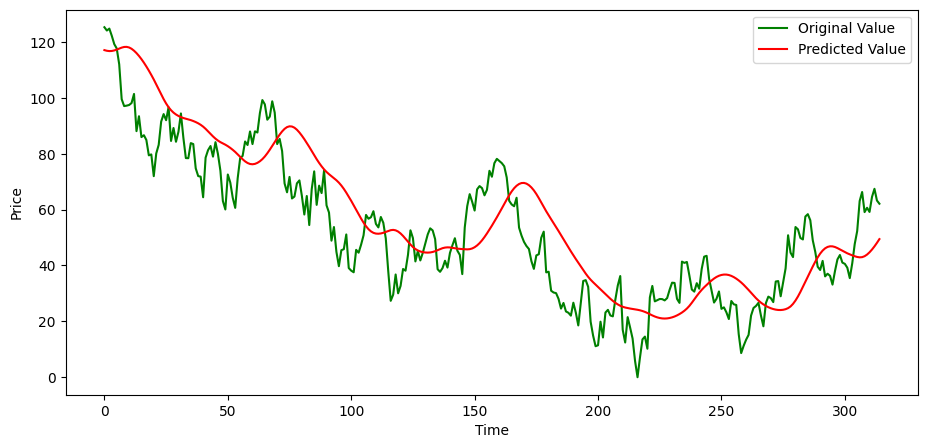

In [56]:
plt.figure(figsize = (11,5))
plt.plot(y_test, 'g', label = 'Original Value')
plt.plot(y_predicted, 'r', label = 'Predicted Value')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [57]:
print(x_test.shape)
print(y_test.shape)

(315, 90, 1)
(315,)


In [58]:
from sklearn.metrics import mean_squared_error
import math

rmse = math.sqrt(mean_squared_error(y_test, y_predicted))
print("RMSE:", rmse)

RMSE: 14.873854167904199


In [59]:
# Preparing testing data
data_testing_array = scaler.transform(data_testing)
x_test = []
y_test = []
for i in range(90, data_testing_array.shape[0]):
    x_test.append(data_testing_array[i-90: i])
    y_test.append(data_testing_array[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)

# Evaluating the model on testing data
test_loss = model.evaluate(x_test, y_test)
print('Test loss:', test_loss)


8/8 [==============================] - 1s 77ms/step - loss: 0.0130
Test loss: 0.012983855791389942


In [60]:
#splitting Data into Training and Testing Testing
data_training = pd.DataFrame(df['Open'][0:int(len(df)*0.75)])
data_testing = pd.DataFrame(df['Open'][int(len(df)*0.75): int(len(df))])

print(data_training.shape)
print(data_testing.shape)

(944, 1)
(315, 1)


In [61]:
data_training.head()

,Open
Date,
2018-03-28 04:00:00+00:00,84.769852
2018-03-29 04:00:00+00:00,85.109602
2018-04-02 04:00:00+00:00,85.383280
2018-04-03 04:00:00+00:00,84.543335
2018-04-04 04:00:00+00:00,82.910597


In [62]:
data_testing.head()

,Open
Date,
2021-12-27 05:00:00+00:00,331.515481
2021-12-28 05:00:00+00:00,339.115080
2021-12-29 05:00:00+00:00,337.286849
2021-12-30 05:00:00+00:00,337.889681
2021-12-31 05:00:00+00:00,334.529700


In [63]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

data_training_array = scaler.fit_transform(data_training)
data_training_array

array([[0.00721601],
       [0.00853462],
       [0.0095968 ],
       [0.00633686],
       [0.        ],
       [0.01681281],
       [0.01333304],
       [0.01168476],
       [0.0166297 ],
       [0.01523775],
       [0.0167761 ],
       [0.02271011],
       [0.02278332],
       [0.02618987],
       [0.03065858],
       [0.03146446],
       [0.02952308],
       [0.02890035],
       [0.03073174],
       [0.01996297],
       [0.02087863],
       [0.03571341],
       [0.03106156],
       [0.01963321],
       [0.02615311],
       [0.01871749],
       [0.02003617],
       [0.02681251],
       [0.02930333],
       [0.02988943],
       [0.03520059],
       [0.03644597],
       [0.0368855 ],
       [0.03439474],
       [0.03638   ],
       [0.03417275],
       [0.03141363],
       [0.03505569],
       [0.03755723],
       [0.03398886],
       [0.04141991],
       [0.03983814],
       [0.03814585],
       [0.0398749 ],
       [0.04348004],
       [0.04344331],
       [0.0507273 ],
       [0.053

In [64]:
data_training_array.shape

(944, 1)

In [65]:
# 1st 90 days x_train
x_train = []
y_train = []

for i in range(90, data_training_array.shape[0]):
    x_train.append(data_training_array[i-90: i])
    y_train.append(data_training_array[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

In [66]:
x_train.shape

(854, 90, 1)

In [67]:
data_training.head()

,Open
Date,
2018-03-28 04:00:00+00:00,84.769852
2018-03-29 04:00:00+00:00,85.109602
2018-04-02 04:00:00+00:00,85.383280
2018-04-03 04:00:00+00:00,84.543335
2018-04-04 04:00:00+00:00,82.910597


In [68]:
data_testing.head()

,Open
Date,
2021-12-27 05:00:00+00:00,331.515481
2021-12-28 05:00:00+00:00,339.115080
2021-12-29 05:00:00+00:00,337.286849
2021-12-30 05:00:00+00:00,337.889681
2021-12-31 05:00:00+00:00,334.529700


In [69]:
past_90_days = data_training.tail(90)

In [70]:
final_df = past_90_days.append(data_testing, ignore_index=True)

<ipython-input-70-a5c55291676a>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = past_90_days.append(data_testing, ignore_index=True)


In [71]:
final_df.head()


,Open
0,288.079034
1,284.774446
2,295.654852
3,299.137030
4,300.882945


In [72]:
input_data = scaler.fit_transform(final_df)
input_data


array([[0.57728721],
       [0.55067404],
       [0.63829832],
       [0.66634169],
       [0.68040225],
       [0.67468266],
       [0.64838753],
       [0.63249918],
       [0.64942006],
       [0.67563647],
       [0.66332255],
       [0.65800004],
       [0.64838731],
       [0.64854643],
       [0.63877509],
       [0.64703746],
       [0.62797114],
       [0.62105923],
       [0.63702745],
       [0.66642111],
       [0.67039314],
       [0.67364985],
       [0.61136745],
       [0.60628336],
       [0.61454536],
       [0.63138685],
       [0.62646142],
       [0.60985809],
       [0.559492  ],
       [0.52215463],
       [0.52700035],
       [0.49848082],
       [0.54042648],
       [0.51381298],
       [0.52755656],
       [0.60223156],
       [0.61049357],
       [0.58427776],
       [0.60350302],
       [0.60008669],
       [0.63424658],
       [0.65911209],
       [0.66888372],
       [0.70685655],
       [0.71368856],
       [0.69748235],
       [0.72314234],
       [0.714

In [73]:
input_data.shape

(405, 1)

In [74]:
x_test = []
y_test = []
for i in range(90, input_data.shape[0]):
    x_test.append(input_data[i-90:i, 0])
    y_test.append(input_data[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)

# reshape the test data
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# make predictions
y_predicted = model.predict(x_test)


10/10 [==============================] - 1s 77ms/step


In [75]:
y_test

array([0.92709836, 0.98830098, 0.9735775 , 0.97843235, 0.95137307,
       0.9262233 , 0.92208471, 0.85069477, 0.74953963, 0.7574985 ,
       0.72041105, 0.75137043, 0.80143066, 0.80779778, 0.67870746,
       0.6772747 , 0.69494329, 0.71706834, 0.66629173, 0.58280522,
       0.57739333, 0.70847277, 0.66605322, 0.64671344, 0.71611337,
       0.72773317, 0.72152512, 0.7204109 , 0.64655413, 0.69398828,
       0.65483157, 0.72343539, 0.67703619, 0.67027122, 0.59530024,
       0.64496239, 0.63682014, 0.62079002, 0.59439216, 0.53019224,
       0.57150386, 0.43058256, 0.61106073, 0.604441  , 0.6211092 ,
       0.61281499, 0.67286836, 0.60428188, 0.55834465, 0.47277129,
       0.51775133, 0.51440132, 0.55379908, 0.49302823, 0.49310816,
       0.56297013, 0.59630655, 0.61289467, 0.64096757, 0.64822448,
       0.65388731, 0.64296151, 0.69153005, 0.68435239, 0.76075419,
       0.75955835, 0.76067455, 0.72454692, 0.73028924, 0.75565019,
       0.6912108 , 0.623183  , 0.65332893, 0.58434388, 0.56400

In [76]:
y_predicted

array([[0.9207079 ],
       [0.917543  ],
       [0.9152047 ],
       [0.91408163],
       [0.9143461 ],
       [0.9158656 ],
       [0.91827065],
       [0.9211497 ],
       [0.9238513 ],
       [0.9254306 ],
       [0.9252451 ],
       [0.92287105],
       [0.91833514],
       [0.9121185 ],
       [0.9048339 ],
       [0.89653355],
       [0.88720137],
       [0.8769638 ],
       [0.8661233 ],
       [0.8548205 ],
       [0.84285706],
       [0.83005846],
       [0.81690395],
       [0.8038211 ],
       [0.79108435],
       [0.77915764],
       [0.7684812 ],
       [0.7593273 ],
       [0.7518009 ],
       [0.7455614 ],
       [0.7403866 ],
       [0.7359413 ],
       [0.7322179 ],
       [0.7290811 ],
       [0.7263539 ],
       [0.72356975],
       [0.72053343],
       [0.71716875],
       [0.71342105],
       [0.7091861 ],
       [0.7041572 ],
       [0.6982848 ],
       [0.6911028 ],
       [0.6829764 ],
       [0.6744551 ],
       [0.66612417],
       [0.6584151 ],
       [0.651

In [77]:
scaler.scale_

array([0.0080534])

In [78]:
scale_factor = 1/0.0080534
y_predicted = y_predicted * scale_factor
y_test = y_test * scale_factor


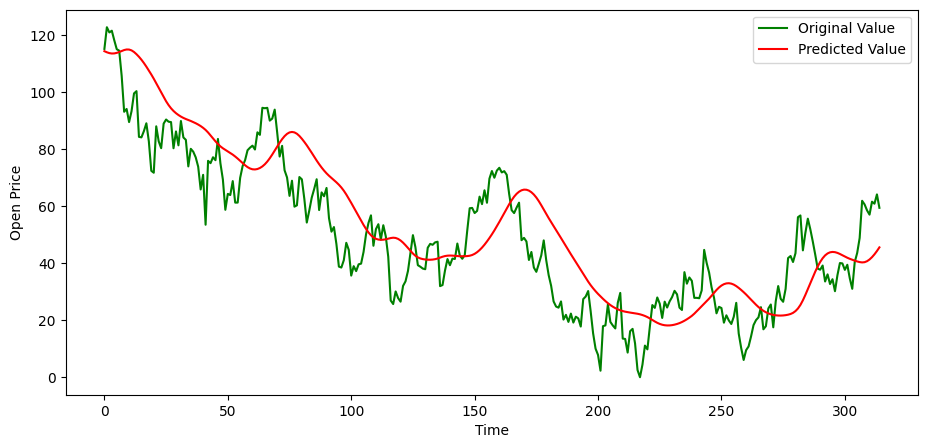

In [79]:
plt.figure(figsize = (11,5))
plt.plot(y_test, 'g', label = 'Original Value')
plt.plot(y_predicted, 'r', label = 'Predicted Value')
plt.xlabel('Time')
plt.ylabel('Open Price')
plt.legend()
plt.show()

In [80]:
print(x_test.shape)
print(y_test.shape)

(315, 90, 1)
(315,)


In [81]:


from sklearn.metrics import mean_squared_error
import math

rmse = math.sqrt(mean_squared_error(y_test, y_predicted))
print(" Open Price RMSE:", rmse)


 Open Price RMSE: 14.647154659791068
